In [1]:
# -*- pecanns -*-
"""
Author: Shamsulhaq Basir
Date  : June 20, 2022
"""

import argparse
import time
import os
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

from torch.optim import LBFGS,Adam
torch.set_default_dtype(torch.float64)
dtype  = torch.float64



%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
import matplotlib as mpl
from matplotlib import ticker

# for reproducibility of the result
torch.manual_seed(123)
# https://pytorch.org/docs/stable/notes/randomness.html
# Completely reproducible results are not guaranteed across PyTorch releases, individual commits, or different platforms. 
# Furthermore, results may not be reproducible between CPU and GPU executions, even when using identical seeds.


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device is :", device)

device is : cpu


In [2]:
global beta
beta = torch.tensor(40.0)

def initial_condition(x,t):
    return torch.sin(x)

In [3]:
def convection_diffusion(nu, beta, source=0, xgrid=128, nt=128):
    # adapted from : https://github.com/a1k12/characterizing-pinns-failure-modes/blob/main/pbc_examples/systems_pbc.py
    """Calculate the u solution for convection/diffusion, assuming PBCs.
    Args:
        u0: Initial condition
        nu: viscosity coefficient
        beta: wavespeed coefficient
        source: q (forcing term), option to have this be a constant
        xgrid: size of the x grid
    Returns:
        u_vals: solution
    """

    N = xgrid
    h = 2 * np.pi / N
    x = np.arange(0, 2*np.pi, h) # not inclusive of the last point
    t = np.linspace(0, 1, nt).reshape(-1, 1)
    X, T = np.meshgrid(x, t)

    # call u0 this way so array is (n, ), so each row of u should also be (n, )
    u0 = lambda x: np.sin(x)
    u0 = u0(x)

    G = (np.copy(u0)*0)+source # G is the same size as u0

    IKX_pos =1j * np.arange(0, N/2+1, 1)
    IKX_neg = 1j * np.arange(-N/2+1, 0, 1)
    IKX = np.concatenate((IKX_pos, IKX_neg))
    IKX2 = IKX * IKX

    uhat0 = np.fft.fft(u0)
    nu_factor = np.exp(nu * IKX2 * T - beta * IKX * T)
    A = uhat0 - np.fft.fft(G)*0 # at t=0, second term goes away
    uhat = A*nu_factor + np.fft.fft(G)*T # for constant, fft(p) dt = fft(p)*T
    u = np.real(np.fft.ifft(uhat))
    return X,T,u

In [4]:
class ConventBlock(nn.Module):
    def __init__(self,in_N,out_N):
        super(ConventBlock, self).__init__()
        self.Ls  = None
        self.net = nn.Sequential(nn.Linear(in_N,out_N),nn.Tanh()) 
    def forward(self, x):
        out = self.net(x)
        return out 
    
    
class Network(torch.nn.Module):
    def __init__(self,layers,**kwargs):
        super(Network,self).__init__()
        self.mu    = kwargs["mean"]
        self.stdev = kwargs["stdev"]
        _layers = [] 
        for i in range(0,len(layers)-2):
            _layers.append(ConventBlock(layers[i],layers[i+1]))
        _layers.append(torch.nn.Linear(layers[-2],layers[-1]))
        self.net = torch.nn.Sequential(*_layers)
        
    def forward(self,x,t):
        data = torch.cat((x,t),dim=1);
        # normalize the input
        data = (data - self.mu)/self.stdev
        out    = self.net(data)
        return out
        
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data)
        nn.init.zeros_(m.bias)

In [5]:
def fetch_residual_points(domain,N_Omega):
    soboleng = torch.quasirandom.SobolEngine(dimension=2,scramble=True)
    data   = soboleng.draw(N_Omega,dtype=dtype)*(domain[1] - domain[0]) + domain[0]
    
    x        = data[:,0][:,None]
    t        = data[:,1][:,None]
    return x,t


In [6]:
def fetch_initial_points(domain,N_data):
    """
    Sampling collocation point:
    Args : 
        - domain :(numpy array) for the size of the domain
        - N_data :(int) number of points 
    out : a tensor of collocation points
    """
    x_min    = domain[0][0]
    x_max    = domain[1][0]
    
    t_min    = domain[0][1]
    
    soboleng = torch.quasirandom.SobolEngine(dimension=1,scramble=True)
    x     = soboleng.draw(N_data,dtype=dtype)*(x_max - x_min) + x_min
    data  = torch.cat((x, torch.full_like(x,t_min)), dim = 1)
    
    x      = data[:,0][:,None]
    t      = data[:,1][:,None]
    return x,t

In [7]:
def fetch_boundary_points(domain,N_data):
    """
    Sampling collocation point:
    Args : 
        - domain :(numpy array) for the size of the domain
        - N_data :(int) number of points 
    out : a tensor of collocation points
    """
    x_min    = domain[0][0]
    x_max    = domain[1][0]
    
    t_min    = domain[0][1]
    t_max    = domain[1][1]
    
    soboleng = torch.quasirandom.SobolEngine(dimension=1,scramble=True)
    t         = soboleng.draw(N_data,dtype=dtype)*(t_max - t_min) + t_min
    x_lbc     = torch.full_like(t,x_min)
    x_ubc     = torch.full_like(t,x_max)
    
    return x_lbc,x_ubc,t

In [8]:
def pde_opt(model,x_dm,t_dm):
    u               = model(x_dm,t_dm)
    u_t,u_x         = torch.autograd.grad(u.sum(),(t_dm,x_dm),create_graph=True)
    physics_loss    = (u_t + beta * u_x).pow(2).sum() 
    return physics_loss

In [9]:
def boundary_opt(model,x_lbc,x_ubc,t, distance_function):
    """ 
        periodic boundary condition 
    """
    u_lbc = model(x_lbc,t) 
    u_ubc = model(x_ubc,t) 
    loss = distance_function(u_lbc, u_ubc)
    return loss


In [10]:
def initial_opt(model,x_ic,t_ic,u_ic,distance_function):
    """
    initial condition : u(x,0) = h(x)
    """
    u   = model(x_ic,t_ic) 
    loss = distance_function(u, u_ic)
    return loss

In [11]:
domain   = np.array([[0.,0.],[2*np.pi,1.]])
kwargs ={"mean":torch.tensor([[3.1416, 0.5]]), "stdev":torch.tensor([[1.8138, 0.2887]])}   

layers = [2,50,50,50,50,1]
model  = Network(layers,**kwargs)
model.apply(init_weights)
print(model)
print(model.mu.shape)
print(model.stdev.shape)

Network(
  (net): Sequential(
    (0): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=2, out_features=50, bias=True)
        (1): Tanh()
      )
    )
    (1): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=50, out_features=50, bias=True)
        (1): Tanh()
      )
    )
    (2): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=50, out_features=50, bias=True)
        (1): Tanh()
      )
    )
    (3): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=50, out_features=50, bias=True)
        (1): Tanh()
      )
    )
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
torch.Size([1, 2])
torch.Size([1, 2])


In [12]:
# sampling collocation points in the domain
N_pde      = 2048
x_dm,t_dm  = fetch_residual_points(domain,N_pde)
x_dm       = x_dm.requires_grad_(True)
t_dm       = t_dm.requires_grad_(True)

# Sampling boundary conditions
N_bc        = 512
x_lbc,x_ubc,t= fetch_boundary_points(domain,N_bc)

# Sampling initial condition points
N_ic       = 512
x_ic,t_ic  = fetch_initial_points(domain,N_ic)
u_ic       = initial_condition(x_ic,t_ic)

In [13]:
distance_function = torch.nn.MSELoss(reduction="none")

In [14]:
lambda_bc    = torch.ones_like(x_lbc)
lambda_ic    = torch.ones_like(x_ic)

v_bc         = torch.zeros_like(x_lbc)
v_ic         = torch.zeros_like(x_ic)

moment         = 0.9
print('momentum',moment)

momentum 0.9


In [15]:
epochs      = 10000

In [16]:
optimizer  = LBFGS(model.parameters(),line_search_fn="strong_wolfe")

In [17]:
# training
for epoch in tqdm(range(1,epochs+1)):

    def closure():
        if torch.is_grad_enabled():
            optimizer.zero_grad()

        # physics loss and flux residual
        physics_loss  = pde_opt(model,x_dm,t_dm)

        # boundary residual 
        boundary_res = boundary_opt(model,x_lbc,x_ubc,t,distance_function)

        # initial residual 
        initial_res  = initial_opt(model,x_ic,t_ic,u_ic,distance_function)
        
        loss          =  physics_loss +\
                        (lambda_bc * boundary_res).sum() +\
                        (lambda_ic * initial_res).sum() 
        
        if loss.requires_grad:
            loss.backward()
        return loss

    def _closure():

        model.eval()
        # boundary residual 
        boundary_res = boundary_opt(model,x_lbc,x_ubc,t,distance_function)
        
        # initial residual 
        initial_res  = initial_opt(model,x_ic,t_ic,u_ic,distance_function)

        return boundary_res,initial_res

    
    # update weights 
    optimizer.step(closure)
    boundary_res,initial_res = _closure()

    with torch.no_grad():
        v_bc  = (1.0 - moment) * boundary_res.pow(2) + moment * v_bc
        v_ic  = (1.0 - moment) * initial_res.pow(2)  + moment * v_ic

        lambda_bc  += 1.0 / ( v_bc + 1e-8).sqrt() * boundary_res
        lambda_ic  += 1.0 / ( v_ic + 1e-8).sqrt() * initial_res
        
        if epoch % 1000 == 0 :
            X,T,u_star = convection_diffusion(nu = 0, beta = beta.numpy(), source=0, xgrid=256, nt=256)
            x_test = torch.from_numpy(X.flatten())[:,None]
            t_test = torch.from_numpy(T.flatten())[:,None]
            u_pred= model(x_test,t_test).detach().reshape(X.shape).numpy()
            L2  = np.linalg.norm(u_star-u_pred, 2)/np.linalg.norm(u_star, 2)
            MAE = np.mean(np.abs(u_star - u_pred))
            print(f'epoch: {epoch:5d}, L2 : {L2:2.3e}, MAE:  {MAE:2.3e}')

 10%|█         | 1000/10000 [10:14<1:39:05,  1.51it/s]

epoch:  1000, L2 : 2.472e-04, MAE:  1.510e-04


 20%|██        | 2003/10000 [13:38<05:12, 25.56it/s]  

epoch:  2000, L2 : 1.437e-04, MAE:  9.521e-05


 30%|███       | 3003/10000 [14:10<04:32, 25.69it/s]

epoch:  3000, L2 : 1.437e-04, MAE:  9.521e-05


 40%|████      | 4004/10000 [17:34<03:40, 27.18it/s]  

epoch:  4000, L2 : 5.930e-05, MAE:  4.719e-05


 50%|█████     | 5004/10000 [18:06<03:03, 27.18it/s]

epoch:  5000, L2 : 5.930e-05, MAE:  4.719e-05


 60%|██████    | 6006/10000 [18:43<02:27, 27.05it/s]

epoch:  6000, L2 : 5.764e-05, MAE:  4.653e-05


 70%|███████   | 7004/10000 [19:16<01:50, 27.08it/s]

epoch:  7000, L2 : 5.787e-05, MAE:  4.656e-05


 80%|████████  | 8004/10000 [19:48<01:13, 27.00it/s]

epoch:  8000, L2 : 5.787e-05, MAE:  4.656e-05


 90%|█████████ | 9004/10000 [20:20<00:36, 27.08it/s]

epoch:  9000, L2 : 5.787e-05, MAE:  4.656e-05


100%|██████████| 10000/10000 [20:52<00:00,  7.98it/s]

epoch: 10000, L2 : 5.787e-05, MAE:  4.656e-05
saving the model


In [ ]:
# saving trained model
file = f"models/conv_equation.pt"
torch.save(model.state_dict(),file)

In [34]:
# https://joseph-long.com/writing/colorbars/
def colorbar(mappable,min_val,max_val,limit):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    ticks = np.linspace(min_val, max_val, 4, endpoint=True)
    cbar = fig.colorbar(mappable, cax=cax,ticks=ticks)
    cbar.formatter.set_powerlimits((limit, limit))
    plt.sca(last_axes)
    return cbar

params = {
    'text.latex.preamble': '\\usepackage{gensymb}',
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 18, # fontsize for x and y labels
    'axes.titlesize': 24,
    'font.size'     : 20, 
    'legend.fontsize': 18, 
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex': False,
    'figure.figsize': [3, 3],
    'font.family': 'serif',
}
plt.rcParams.update(params)
cmap_list = ['jet','YlGnBu','coolwarm','rainbow','magma','plasma','inferno','Spectral','RdBu']
cmap = plt.cm.get_cmap(cmap_list[8]).reversed()

In [35]:
# saving trained model
file = f"models/conv_equation.pt"
model.load_state_dict(torch.load(file))
model.eval()

X,T,u_star = convection_diffusion(nu = 0, beta = beta.numpy(), source=0, xgrid=256, nt=256)
x_test = torch.from_numpy(X.flatten())[:,None]
t_test = torch.from_numpy(T.flatten())[:,None]
u_pred= model(x_test,t_test).detach().reshape(X.shape).numpy()


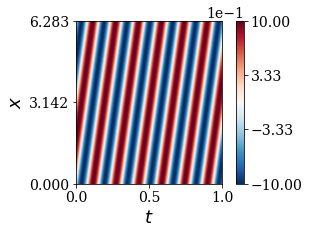

In [36]:
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0,0])
img=ax.pcolormesh(T,X,u_pred,cmap=cmap,shading='gouraud')
cbar = colorbar(img,min_val=np.amin(u_pred),max_val=np.amax(u_pred),limit=-1)
ax.set_yticks([domain[0][0],(domain[1][0]+ domain[0][0])/2,domain[1][0]])
ax.set_xticks([domain[0][1],(domain[1][1]+domain[0][1])/2,domain[1][1]])
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
filename="figures/convection_prediction"
plt.savefig('{}.png'.format(filename), bbox_inches='tight', pad_inches=0.01)
plt.show()

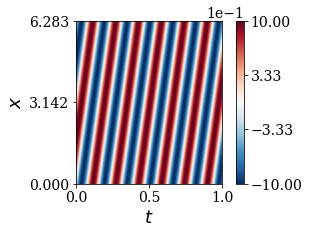

In [37]:
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0,0])
img=ax.pcolormesh(T,X,u_star,shading='gouraud',cmap=cmap)
cbar = colorbar(img,min_val=np.amin(u_star),max_val=np.amax(u_star),limit=-1)
ax.set_yticks([domain[0][0],(domain[1][0]+ domain[0][0])/2,domain[1][0]])
ax.set_xticks([domain[0][1],(domain[1][1]+domain[0][1])/2,domain[1][1]])
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
filename="figures/convection_exact"
plt.savefig('{}.png'.format(filename), bbox_inches='tight', pad_inches=0.01)
plt.show()

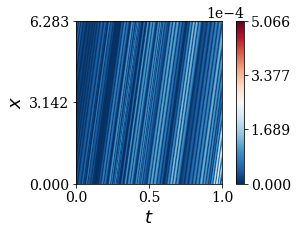

In [38]:
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0,0])

error = np.abs(u_star - u_pred)
max_val= np.amin(error)
min_val= np.amax(error)
img=ax.pcolormesh(T,X,error,shading='gouraud',cmap=cmap)
ax.set_xticks([0,0.5,1])
ax.set_yticks([0,0.5,1])
cbar = colorbar(img,min_val,max_val,limit=-4)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_yticks([domain[0][0],(domain[1][0]+ domain[0][0])/2,domain[1][0]])
ax.set_xticks([domain[0][1],(domain[1][1]+domain[0][1])/2,domain[1][1]])

filename="figures/convection_absolute_error"
plt.savefig('{}.png'.format(filename), bbox_inches='tight', pad_inches=0.01)
plt.show()